# DACON - 영화 관객수 예측 경진대회
[DACON - 영화 관객수 예측 경진대회](https://dacon.io/competitions/open/235536/data)
## EDA and Preprocessing

### 사용 라이브러리



In [2]:
!pip install lightgbm

     ---------------------------------------- 1.0/1.0 MB 8.1 MB/s eta 0:00:00



[notice] A new release of pip available: 22.3 -> 22.3.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import koreanize_matplotlib
import re
import glob
import warnings
warnings.filterwarnings("ignore")

from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, accuracy_score

import xgboost as xgb
from xgboost import XGBRegressor

import lightgbm as lgbm
from lightgbm import LGBMRegressor

xgboost와 lgbm을 사용했지만, 다른 모델을 사용해도 상관 없습니다

### Data Load

In [14]:
from glob import glob

paths = glob("./data/*")
paths

['./data\\movies_test.csv',
 './data\\movies_train.csv',
 './data\\submission.csv']

In [15]:
train, test = pd.read_csv(paths[1]), pd.read_csv(paths[0])

train.shape, test.shape

((600, 12), (243, 11))

In [17]:
# train과 test의 데이터를 출력해봅니다
display(train.head(3))
display(test.head(3))

,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
0,개들의 전쟁,롯데엔터테인먼트,액션,2012-11-22,96,청소년 관람불가,조병옥,NaN,0,91,2,23398
1,내부자들,(주)쇼박스,느와르,2015-11-19,130,청소년 관람불가,우민호,1161602.50,2,387,3,7072501
2,은밀하게 위대하게,(주)쇼박스,액션,2013-06-05,123,15세 관람가,장철수,220775.25,4,343,4,6959083


,title,distributor,genre,release_time,time,screening_rat,director,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
0,용서는 없다,시네마서비스,느와르,2010-01-07,125,청소년 관람불가,김형준,3.005290e+05,2,304,3
1,아빠가 여자를 좋아해,(주)쇼박스,멜로/로맨스,2010-01-14,113,12세 관람가,이광재,3.427002e+05,4,275,3
2,하모니,CJ 엔터테인먼트,드라마,2010-01-28,115,12세 관람가,강대규,4.206611e+06,3,419,7


- title : 영화의 제목
- distributor : 배급사
- genre : 장르
- release_time : 개봉일
- time : 상영시간(분)
- screening_rat : 상영등급
- director : 감독이름
- dir_prev_bfnum : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수(단 관객수가 알려지지 않은 영화 제외)
- dir_prev_num : 해당 감독이 이 영화를 만들기 전 제작에 참여한 영화의 개수(단 관객수가 알려지지 않은 영화 제외)
- num_staff : 스텝수
- num_actor : 주연배우수
- box_off_num : 관객수

### EDA and Preprocessing
#### 기본 정보

In [18]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 600 entries, 0 to 599
Data columns (total 12 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           600 non-null    object 
 1   distributor     600 non-null    object 
 2   genre           600 non-null    object 
 3   release_time    600 non-null    object 
 4   time            600 non-null    int64  
 5   screening_rat   600 non-null    object 
 6   director        600 non-null    object 
 7   dir_prev_bfnum  270 non-null    float64
 8   dir_prev_num    600 non-null    int64  
 9   num_staff       600 non-null    int64  
 10  num_actor       600 non-null    int64  
 11  box_off_num     600 non-null    int64  
dtypes: float64(1), int64(5), object(6)
memory usage: 56.4+ KB


In [29]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (train)
with pd.option_context('display.float_format', '${:0.2f}'.format):
   display(train.describe())


,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor,box_off_num
count,$600.00,$270.00,$600.00,$600.00,$600.00,$600.00
mean,$100.86,$1050442.89,$0.88,$151.12,$3.71,$708181.75
std,$18.10,$1791408.30,$1.18,$165.65,$2.45,$1828005.85
min,$45.00,$1.00,$0.00,$0.00,$0.00,$1.00
25%,$89.00,$20380.00,$0.00,$17.00,$2.00,$1297.25
50%,$100.00,$478423.62,$0.00,$82.50,$3.00,$12591.00
75%,$114.00,$1286568.62,$2.00,$264.00,$4.00,$479886.75
max,$180.00,$17615314.00,$5.00,$869.00,$25.00,$14262766.00


In [30]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 243 entries, 0 to 242
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   title           243 non-null    object 
 1   distributor     243 non-null    object 
 2   genre           243 non-null    object 
 3   release_time    243 non-null    object 
 4   time            243 non-null    int64  
 5   screening_rat   243 non-null    object 
 6   director        243 non-null    object 
 7   dir_prev_bfnum  107 non-null    float64
 8   dir_prev_num    243 non-null    int64  
 9   num_staff       243 non-null    int64  
 10  num_actor       243 non-null    int64  
dtypes: float64(1), int64(4), object(6)
memory usage: 21.0+ KB


In [33]:
# 통계값을 소수점 2자리까지만 확인 해봅니다 (test)
with pd.option_context('display.float_format', '${:0.2f}'.format):
   display(test.describe())

,time,dir_prev_bfnum,dir_prev_num,num_staff,num_actor
count,$243.00,$107.00,$243.00,$243.00,$243.00
mean,$109.80,$891669.52,$0.85,$159.32,$3.48
std,$124.02,$1217341.45,$1.20,$162.98,$2.11
min,$40.00,$34.00,$0.00,$0.00,$0.00
25%,$91.00,$62502.00,$0.00,$18.00,$2.00
50%,$104.00,$493120.00,$0.00,$105.00,$3.00
75%,$114.50,$1080849.58,$1.00,$282.00,$4.00
max,$2015.00,$6173099.50,$6.00,$776.00,$16.00


#### 결측치 확인

In [34]:
# train
train.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    330
dir_prev_num        0
num_staff           0
num_actor           0
box_off_num         0
dtype: int64

In [35]:
# test
test.isnull().sum()

title               0
distributor         0
genre               0
release_time        0
time                0
screening_rat       0
director            0
dir_prev_bfnum    136
dir_prev_num        0
num_staff           0
num_actor           0
dtype: int64

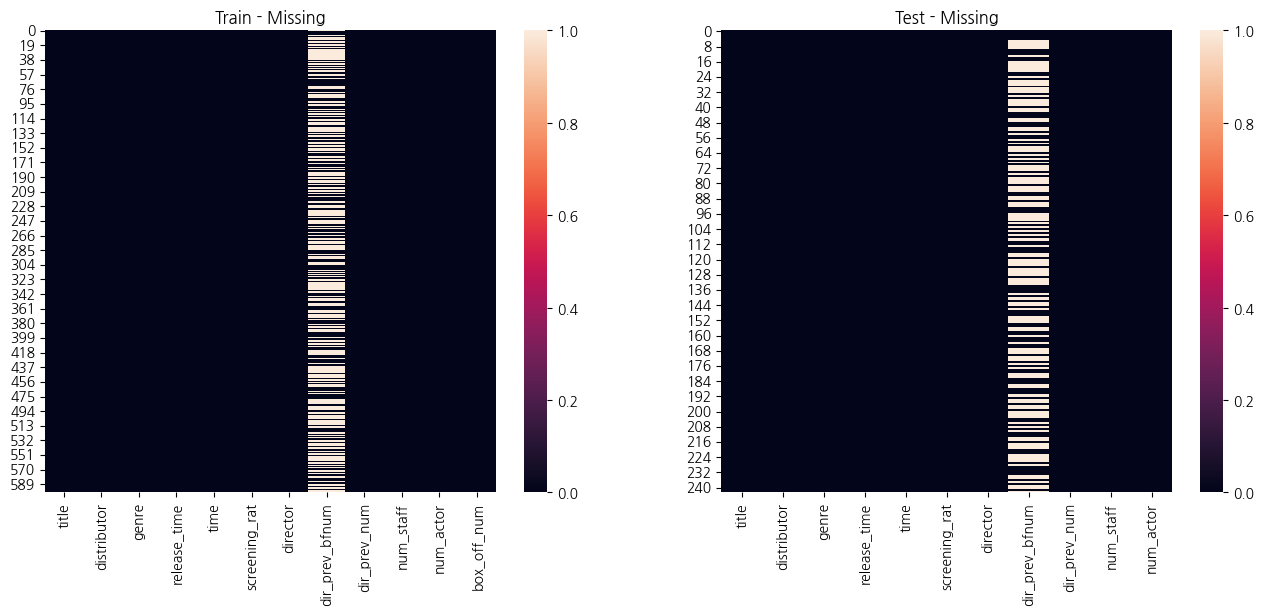

In [39]:
# 결측치를 시각화해봅니다
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,6))
_ = sns.heatmap(train.isnull(), ax=axes[0]).set_title("Train - Missing")
_ = sns.heatmap(test.isnull(), ax=axes[1]).set_title("Test - Missing")

`dir_prev_bfnum`은 해당 감독이 영화를 만들기 전 제작에 참여한 영화에서의 평균 관객수부분에 결측치가 존재함  
관객수가 알려지지 않은 부분이 결측치로 존재하는거라, 정보가 없다라는 정보 그 자체로 사용해도 괜찮을꺼 같음

#### distributor: 배급사

In [44]:
# \(|주|\) 는 데이터에서 제거해줍니다
train["distributor"].head()

0        롯데엔터테인먼트
1          (주)쇼박스
2          (주)쇼박스
3          (주)NEW
4    쇼박스(주)미디어플렉스
Name: distributor, dtype: object

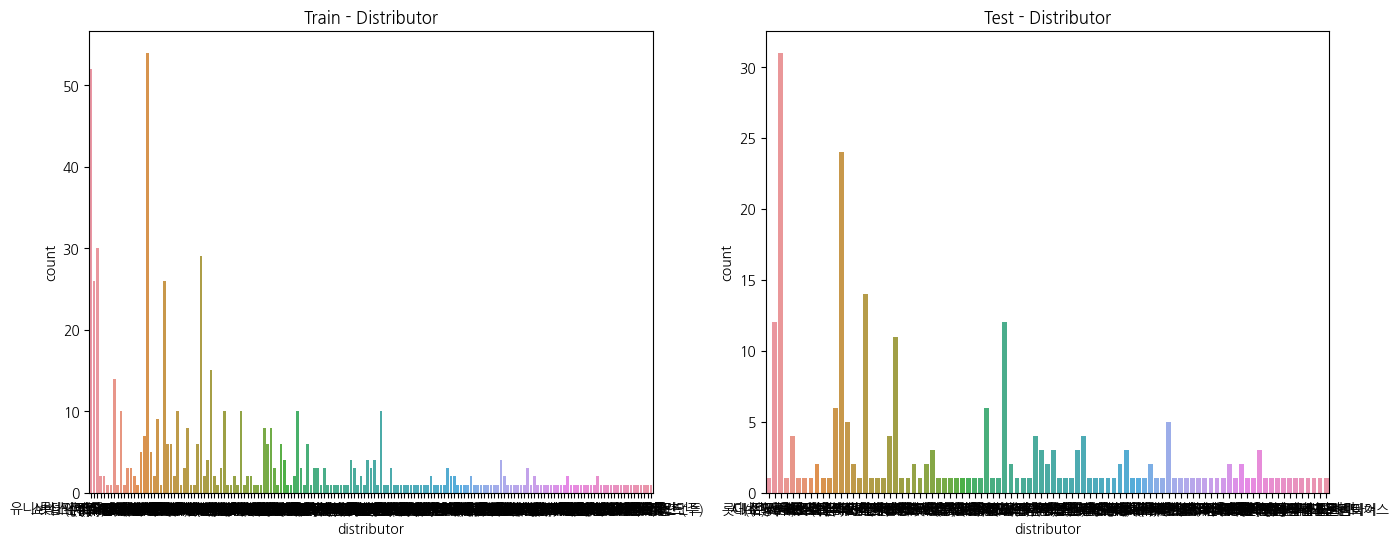

In [45]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(16,6))
_ = sns.countplot(data=train, x="distributor", ax=axes[0]).set_title("Train - Distributor")
_ = sns.countplot(data=test, x="distributor", ax=axes[1]).set_title("Test - Distributor")

In [48]:
[re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]

['롯데엔터테인먼트',
 '주쇼박스',
 '주쇼박스',
 '주NEW',
 '쇼박스주미디어플렉스',
 '롯데엔터테인먼트',
 '백두대간',
 '주쇼박스',
 '유니버설픽쳐스인터내셔널코리아',
 '주두타연',
 '주케이알씨지',
 '주콘텐츠윙',
 '주키노아이',
 '주팝파트너스',
 'CJEM영화부문',
 '주영화제작전원사',
 'CJEMPictures',
 'CGV무비꼴라쥬',
 '리틀빅픽처스',
 '스폰지',
 'CJ엔터테인먼트',
 'CGV아트하우스',
 '조이앤시네마',
 '롯데엔터테인먼트',
 '인디플러그',
 '콘텐츠판다',
 '인디스토리',
 '주케이알씨지',
 '주NEW',
 '주팝엔터테인먼트',
 '시네마서비스',
 '웃기씨네',
 'CJ엔터테인먼트',
 '인디스토리',
 'CJ엔터테인먼트',
 '영화사진진',
 '주레인보우팩토리',
 '김기덕필름',
 '영화사진진',
 'NEW',
 'CJCGV',
 '롯데엔터테인먼트',
 '동국대학교충무로영상제작센터',
 'BoXoo엔터테인먼트',
 'CJ엔터테인먼트',
 '주마운틴픽쳐스',
 'CJ엔터테인먼트',
 'CGV아트하우스',
 '주NEW',
 '메가박스주플러스엠',
 '골든타이드픽처스',
 '메가박스주플러스엠',
 '파이오니아21',
 '디씨드',
 '주마운틴픽쳐스',
 '주쇼박스',
 '드림팩트엔터테인먼트',
 '주케이알씨지',
 '시너지',
 '롯데엔터테인먼트',
 '리틀빅픽처스',
 '디마엔터테인먼트',
 '판다미디어',
 '롯데엔터테인먼트',
 '주케이알씨지',
 'CJ엔터테인먼트',
 '주쇼박스',
 '주NEW',
 '골든타이드픽처스',
 '주스톰픽쳐스코리아',
 '주마운틴픽쳐스',
 '주마운틴픽쳐스',
 '주예지림엔터테인먼트',
 '주마운틴픽쳐스',
 'CJ엔터테인먼트',
 '골든타이드픽처스',
 '롯데엔터테인먼트',
 '주스톰픽쳐스코리아',
 '롯데엔터테인먼트',
 '주영화사조제',
 '주케이알씨지',
 '롯데엔터테인먼트',
 '보람엔터테인먼트',
 '인디스토리',
 'CJ엔터테인먼트

In [49]:
# 정규 표현식으로 문자와 숫자만 
train["distributor"] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in train.distributor]
test['distributor'] = [re.sub(r'[^0-9a-zA-Z가-힣]', '', x) for x in test.distributor]

In [51]:
display(train[["distributor"]].head())
display(test[["distributor"]].head())

,distributor
0,롯데엔터테인먼트
1,주쇼박스
2,주쇼박스
3,주NEW
4,쇼박스주미디어플렉스


,distributor
0,시네마서비스
1,주쇼박스
2,CJ엔터테인먼트
3,주쇼박스
4,CJ엔터테인먼트


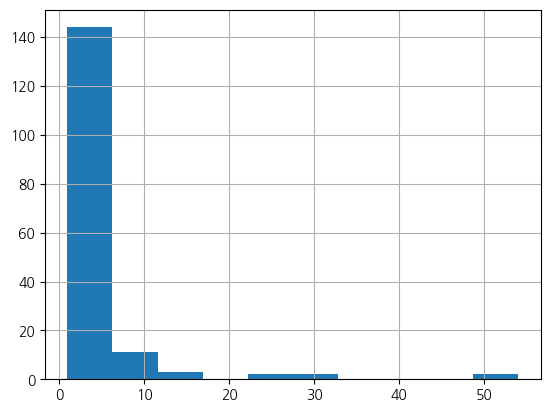

In [52]:
_ = train["distributor"].value_counts().hist()

In [63]:
distributor_counts = train["distributor"].value_counts()
중대형 = distributor_counts[distributor_counts > 15].index.to_list()

In [70]:
# 배급사의 개수를 이용해 소형, 중대형으로 분리하기 위한 함수를 작성합니다
# 15개 이하면 소형, 이외면 중대형으로 분류 합니다
def distributor_band(x):
    return "중대형" if x in 중대형 else "소형"


In [71]:
train["distributor"].apply(distributor_band).value_counts()

소형     367
중대형    233
Name: distributor, dtype: int64

In [74]:
# 위 함수를 train과 test에 모두 적용합니다
train["distributor"] = train["distributor"].apply(distributor_band)
test["distributor"] = test["distributor"].apply(distributor_band)

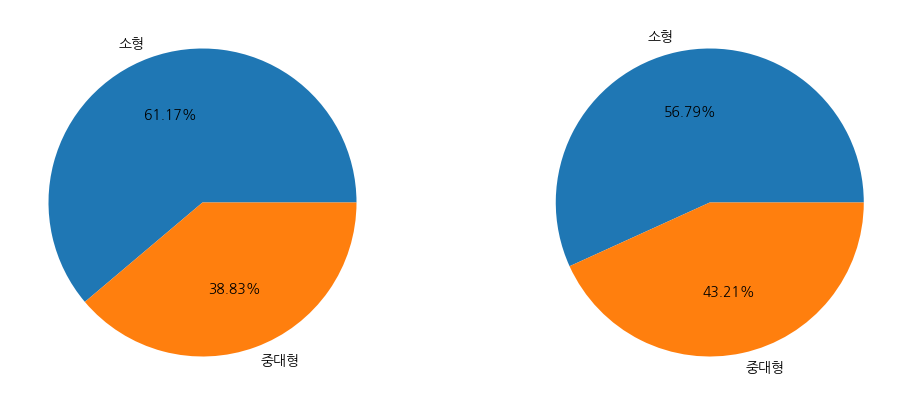

In [75]:
# pie 차트는 다음과 같이 그릴 수 있습니다
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
ax[0].pie(train["distributor"].value_counts().values, labels=train["distributor"].value_counts().index, autopct="%.2f%%")
ax[1].pie(test["distributor"].value_counts().values, labels=test["distributor"].value_counts().index, autopct="%.2f%%")
plt.show()

#### genre: 장르


In [77]:
genre_s =  train.groupby("genre")["box_off_num"].mean().sort_values()
genre_s

genre
뮤지컬       6.627000e+03
다큐멘터리     6.717226e+04
서스펜스      8.261100e+04
애니메이션     1.819267e+05
멜로/로맨스    4.259680e+05
미스터리      5.275482e+05
공포        5.908325e+05
드라마       6.256898e+05
코미디       1.193914e+06
SF        1.788346e+06
액션        2.203974e+06
느와르       2.263695e+06
Name: box_off_num, dtype: float64

In [86]:
# 위에서 구한 장르로
# rank 딕셔너리를 하드코딩합니다
# 인코딩하는 과정입니다

rank = genre_s.to_dict()
rank


{'뮤지컬': 6627.0,
 '다큐멘터리': 67172.25806451614,
 '서스펜스': 82611.0,
 '애니메이션': 181926.66666666666,
 '멜로/로맨스': 425968.03846153844,
 '미스터리': 527548.1764705882,
 '공포': 590832.5238095238,
 '드라마': 625689.7918552036,
 '코미디': 1193914.0,
 'SF': 1788345.6923076923,
 '액션': 2203974.0714285714,
 '느와르': 2263695.111111111}

In [87]:
train["rank_genre"] = train["genre"].apply(lambda x: rank[x])
test["rank_genre"] = test["genre"].apply(lambda x: rank[x])

In [89]:
# 인코딩 전의 장르 컬럼은 버려줍니다
train = train.drop(columns="genre")
test = test.drop(columns="genre")

### release_time: 개봉일

In [91]:
# 개봉일의 데이터타입은 datetime으로 변경합니다
train["release_time"] = pd.to_datetime(train["release_time"])
train["release_time"]

0     2012-11-22
1     2015-11-19
2     2013-06-05
3     2012-07-12
4     2010-11-04
         ...    
595   2014-08-13
596   2013-03-14
597   2010-09-30
598   2015-05-14
599   2013-01-30
Name: release_time, Length: 600, dtype: datetime64[ns]

In [96]:
# 연 월 일 요일 파생 변수를 train과 test에 생성합니다
train["year"] = train.release_time.dt.year
train["month"] = train.release_time.dt.month
train["day"] = train.release_time.dt.day
train["dayofweek"] = train.release_time.dt.day_of_week

In [98]:
test["release_time"] = pd.to_datetime(test["release_time"])
test["year"] = test.release_time.dt.year
test["month"] = test.release_time.dt.month
test["day"] = test.release_time.dt.day
test["dayofweek"] = test.release_time.dt.day_of_week

In [99]:
# 기존 데이터는 삭제합니다
train = train.drop(columns="release_time")
test = test.drop(columns="release_time")

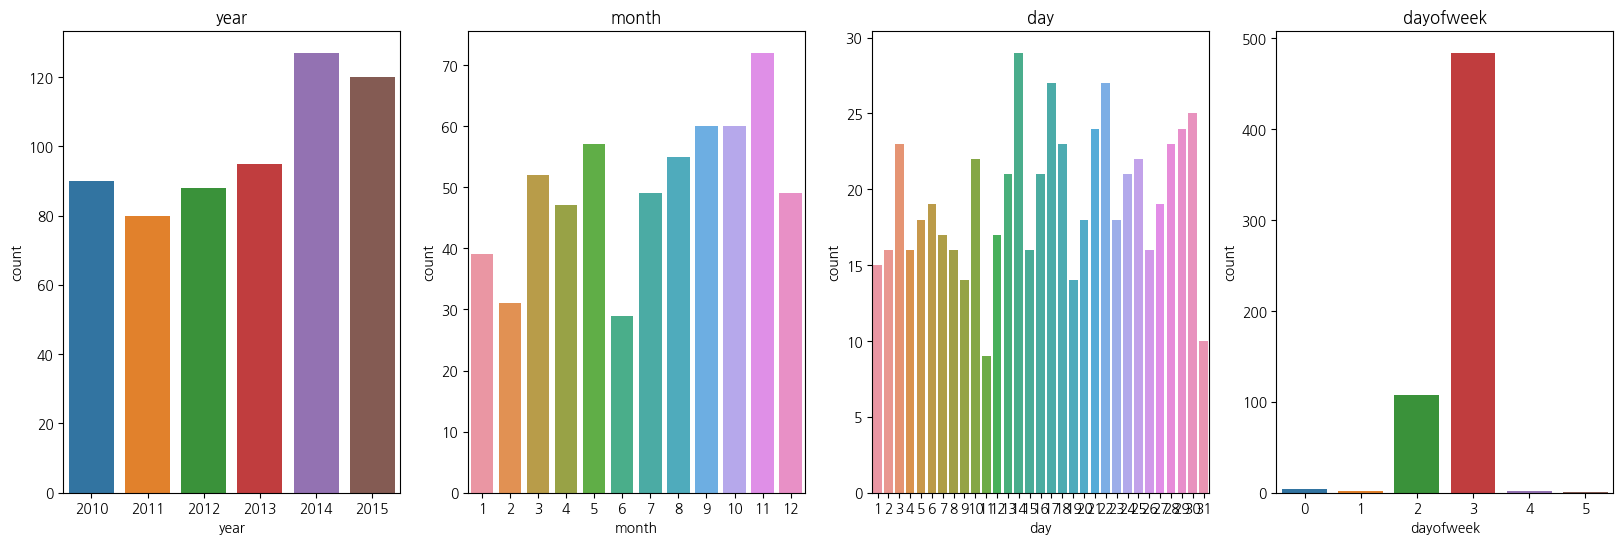

In [100]:
# 요일별로 시각화 해봅니다
fig, axes = plt.subplots(1, 4, figsize=(20, 6))
_ = sns.countplot(data=train, x=train.year, ax=axes[0]).set_title("year")
_ = sns.countplot(data=train, x=train.month, ax=axes[1]).set_title("month")
_ = sns.countplot(data=train, x=train.day, ax=axes[2]).set_title("day")
_ = sns.countplot(data=train, x=train.dayofweek, ax=axes[3]).set_title("dayofweek")

수요일, 목요일에 개봉한 영화들이 많고 목요일에 개봉한 영화가 유독 많음

## Train

In [105]:
train.columns

Index(['distributor', 'time', 'screening_rat', 'dir_prev_bfnum',
       'dir_prev_num', 'num_staff', 'num_actor', 'box_off_num', 'rank_genre',
       'year', 'month', 'day', 'dayofweek'],
      dtype='object')

In [103]:
# 제목과 감독 데이터는 버려줍니다
train = train.drop(columns=["title", "director"])
test = test.drop(columns=["title", "director"])

In [104]:
train["dir_prev_bfnum"].fillna(0, inplace=True)
test["dir_prev_bfnum"].fillna(0, inplace=True)

In [110]:
# 범주형 데이터들을 인코딩해줍니다
train = pd.get_dummies(train)
test = pd.get_dummies(test)

In [112]:
set(train.columns) - set(test.columns)

{'box_off_num'}

In [115]:
# 피처와 라벨을 구합니다
label_name = "box_off_num"
feature_names = train.columns.to_list()
feature_names.remove(label_name)
feature_names

['time',
 'dir_prev_bfnum',
 'dir_prev_num',
 'num_staff',
 'num_actor',
 'rank_genre',
 'year',
 'month',
 'day',
 'dayofweek',
 'distributor_소형',
 'distributor_중대형',
 'screening_rat_12세 관람가',
 'screening_rat_15세 관람가',
 'screening_rat_전체 관람가',
 'screening_rat_청소년 관람불가']

### Log Scale

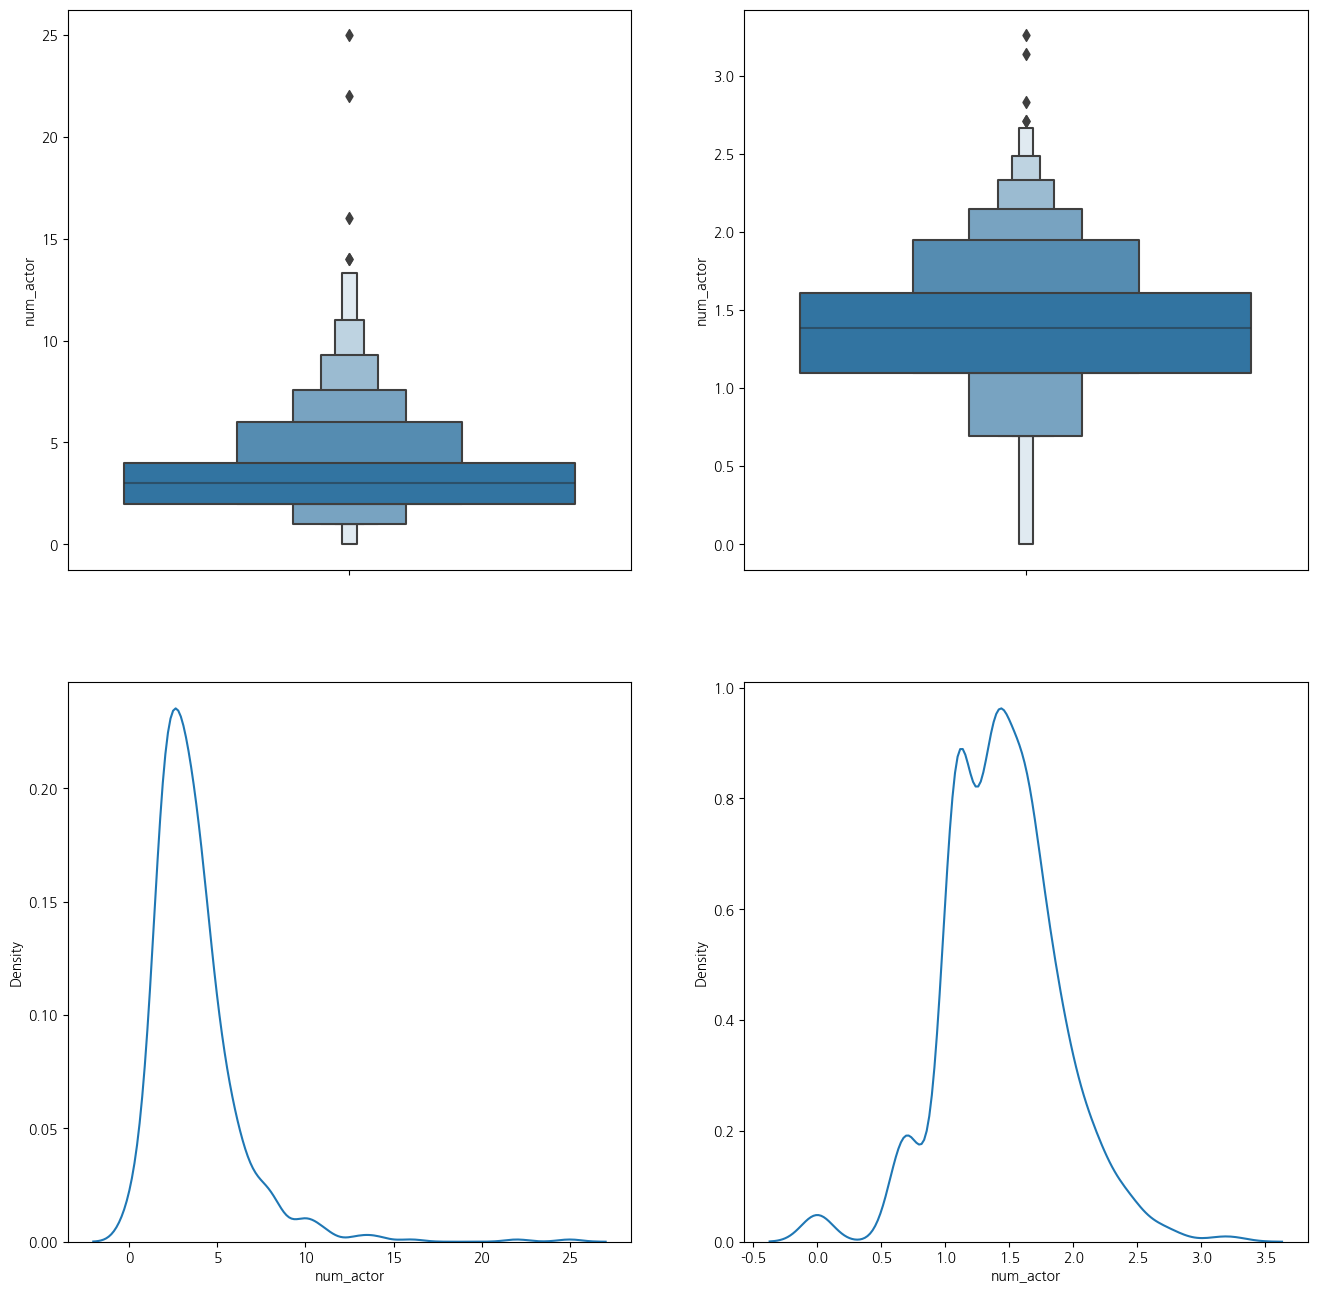

In [123]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
_ = sns.boxenplot(data=train, y=train.num_actor, ax=axes[0][0])
_ = sns.boxenplot(data=train, y=np.log1p(train.num_actor), ax=axes[0][1])
_ = sns.kdeplot(data=train, x=train.num_actor, ax=axes[1][0])
_ = sns.kdeplot(data=train, x=np.log1p(train.num_actor), ax=axes[1][1])


In [124]:
# 등장 배우의 수에 로그 스케일을 적용합니다
train.num_actor = np.log1p(train.num_actor)
test.num_actor = np.log1p(test.num_actor)

In [125]:
X_train, X_val, y_train, y_val = train_test_split(train[feature_names], train[label_name], test_size=0.15)

print(f"X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_val: {X_val.shape}\ny_val: {y_val.shape}")

X_train: (510, 16)
y_train: (510,)
X_val: (90, 16)
y_val: (90,)


In [126]:
test.shape

(243, 16)

### Random Forest

In [134]:
from sklearn.ensemble import RandomForestRegressor

rmodel = RandomForestRegressor(random_state=42, max_features=0.8, min_samples_split=3)
rmodel.fit(X_train, y_train)
y_predict = rmodel.predict(X_val)

(((y_val - y_predict)**2).mean())**0.5

1373208.0941147925

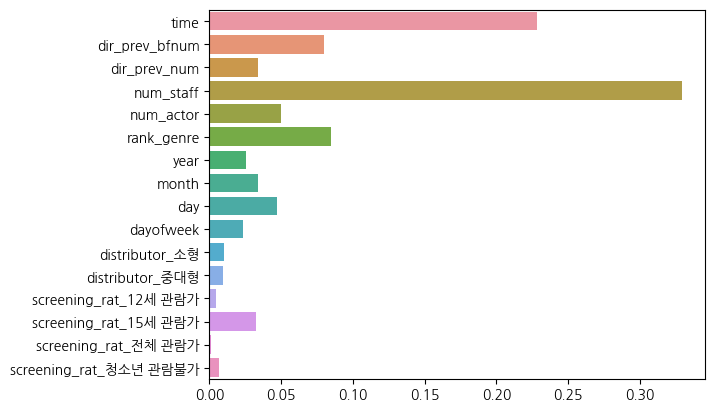

In [135]:
_ = sns.barplot(x=rmodel.feature_importances_, y=rmodel.feature_names_in_)

### XGBoost

In [139]:
from xgboost import XGBRFRegressor

xmodel = XGBRFRegressor(random_state=42, n_jobs=-1, learning_rate=0.8)
xmodel.fit(X_train, y_train)
y_xpredict = xmodel.predict(X_val)

(((y_val - y_xpredict)**2).mean())**0.5

1389336.7623611256

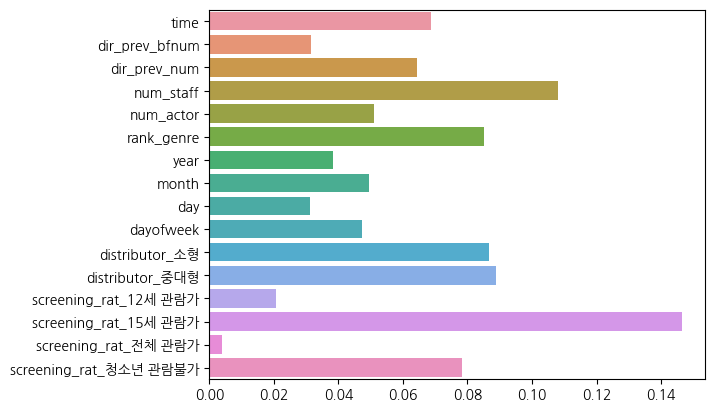

In [140]:
_ = sns.barplot(x=xmodel.feature_importances_, y=xmodel.feature_names_in_)

### LightGBM

In [155]:
from lightgbm import LGBMRegressor

lmodel = LGBMRegressor(random_state=42, n_jobs=-1, learning_rate=0.08)
lmodel.fit(X_train, y_train)
y_xpredict = lmodel.predict(X_val)

(((y_val - y_xpredict)**2).mean())**0.5

1435016.435223182